In [22]:
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from preprocessor import get_dataset, get_and_process_data, decoding, load_and_process_example
from qwen import load_qwen
import joblib

In [2]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
file_path = 'lotka_volterra_data.h5'

In [5]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

In [6]:
def evaluate(model, tokenizer, file_path, system_ids):
    actual_preys = []
    actual_predators = []
    predicted_preys = []
    predicted_predators = []
    full_dataset = []
    for id in system_ids:
        full_tokenized_data, full_preprocessed_data, full_data, full_times = load_and_process_example(file_path, tokenizer, points=100, alpha=5, decimals=3, seed=442, id=id)
        max_token_length = max(full_tokenized_data["input_ids"].shape[1]+1, 1200)
        actual_prey = full_data[:,2]
        actual_predator = full_data[:,3]

        part_tokenized_data, part_preprocessed_data, part_data, part_times = load_and_process_example(file_path, tokenizer, points=80, alpha=5, decimals=3, seed=442, id=id)
        model.eval()
        with torch.no_grad():
            output = model.generate(part_tokenized_data["input_ids"], attention_mask = part_tokenized_data["attention_mask"], max_new_tokens=max_token_length)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        pred_prey, pred_predator = decoding(prediction)

        actual_preys.append(actual_prey)
        actual_predators.append(actual_predator)
        predicted_preys.append(pred_prey)
        predicted_predators.append(pred_predator)
        full_dataset.append(full_data)

    return actual_preys, actual_predators, predicted_preys, predicted_predators, full_times, full_dataset

In [20]:
def get_metrics(actual_preys, actual_predators, pred_preys, pred_predators):
    metrics = []
    for actual_prey, actual_predator, pred_prey, pred_predator in zip(actual_preys, actual_predators, pred_preys, pred_predators):
        mse_prey = mean_squared_error(actual_prey[80:], pred_prey[80:])
        mse_predator = mean_squared_error(actual_predator[80:], pred_predator[80:])
        mae_prey = mean_absolute_error(actual_prey[80:], pred_prey[80:])
        mae_predator = mean_absolute_error(actual_predator[80:], pred_predator[80:])
        mape_prey = mean_absolute_percentage_error(actual_prey[80:], pred_prey[80:])
        mape_predator = mean_absolute_percentage_error(actual_predator[80:], pred_predator[80:])
        rmse_prey = root_mean_squared_error(actual_prey[80:], pred_prey[80:])
        rmse_predator = root_mean_squared_error(actual_predator[80:], pred_predator[80:])
        running_mse_prey = running_mse(pred_prey[80:], actual_prey[80:])
        running_mse_predator = running_mse(pred_predator[80:], actual_predator[80:])
        metrics.append((mse_prey, mse_predator, mae_prey, mae_predator, mape_prey, mape_predator, rmse_prey, rmse_predator, running_mse_prey, running_mse_predator))
    return metrics

In [ ]:
system_ids = [0, 10, 15, 91]
actual_system_ids = [506, 20, 654, 906]
# actual_preys, actual_predators, predicted_preys, predicted_predators, full_times, full_dataset = evaluate(model, tokenizer, file_path, system_ids=system_ids)
# joblib.dump((actual_preys, actual_predators, predicted_preys, predicted_predators, full_times, full_dataset), 'evaluations.pkl')
actual_preys, actual_predators, predicted_preys, predicted_predators, full_times, full_dataset = joblib.load('evaluations.pkl')

In [11]:
for i, id in enumerate(system_ids):
    aprey = actual_preys[i]
    apredator = actual_predators[i]
    pprey = predicted_preys[i]
    ppredator = predicted_predators[i]

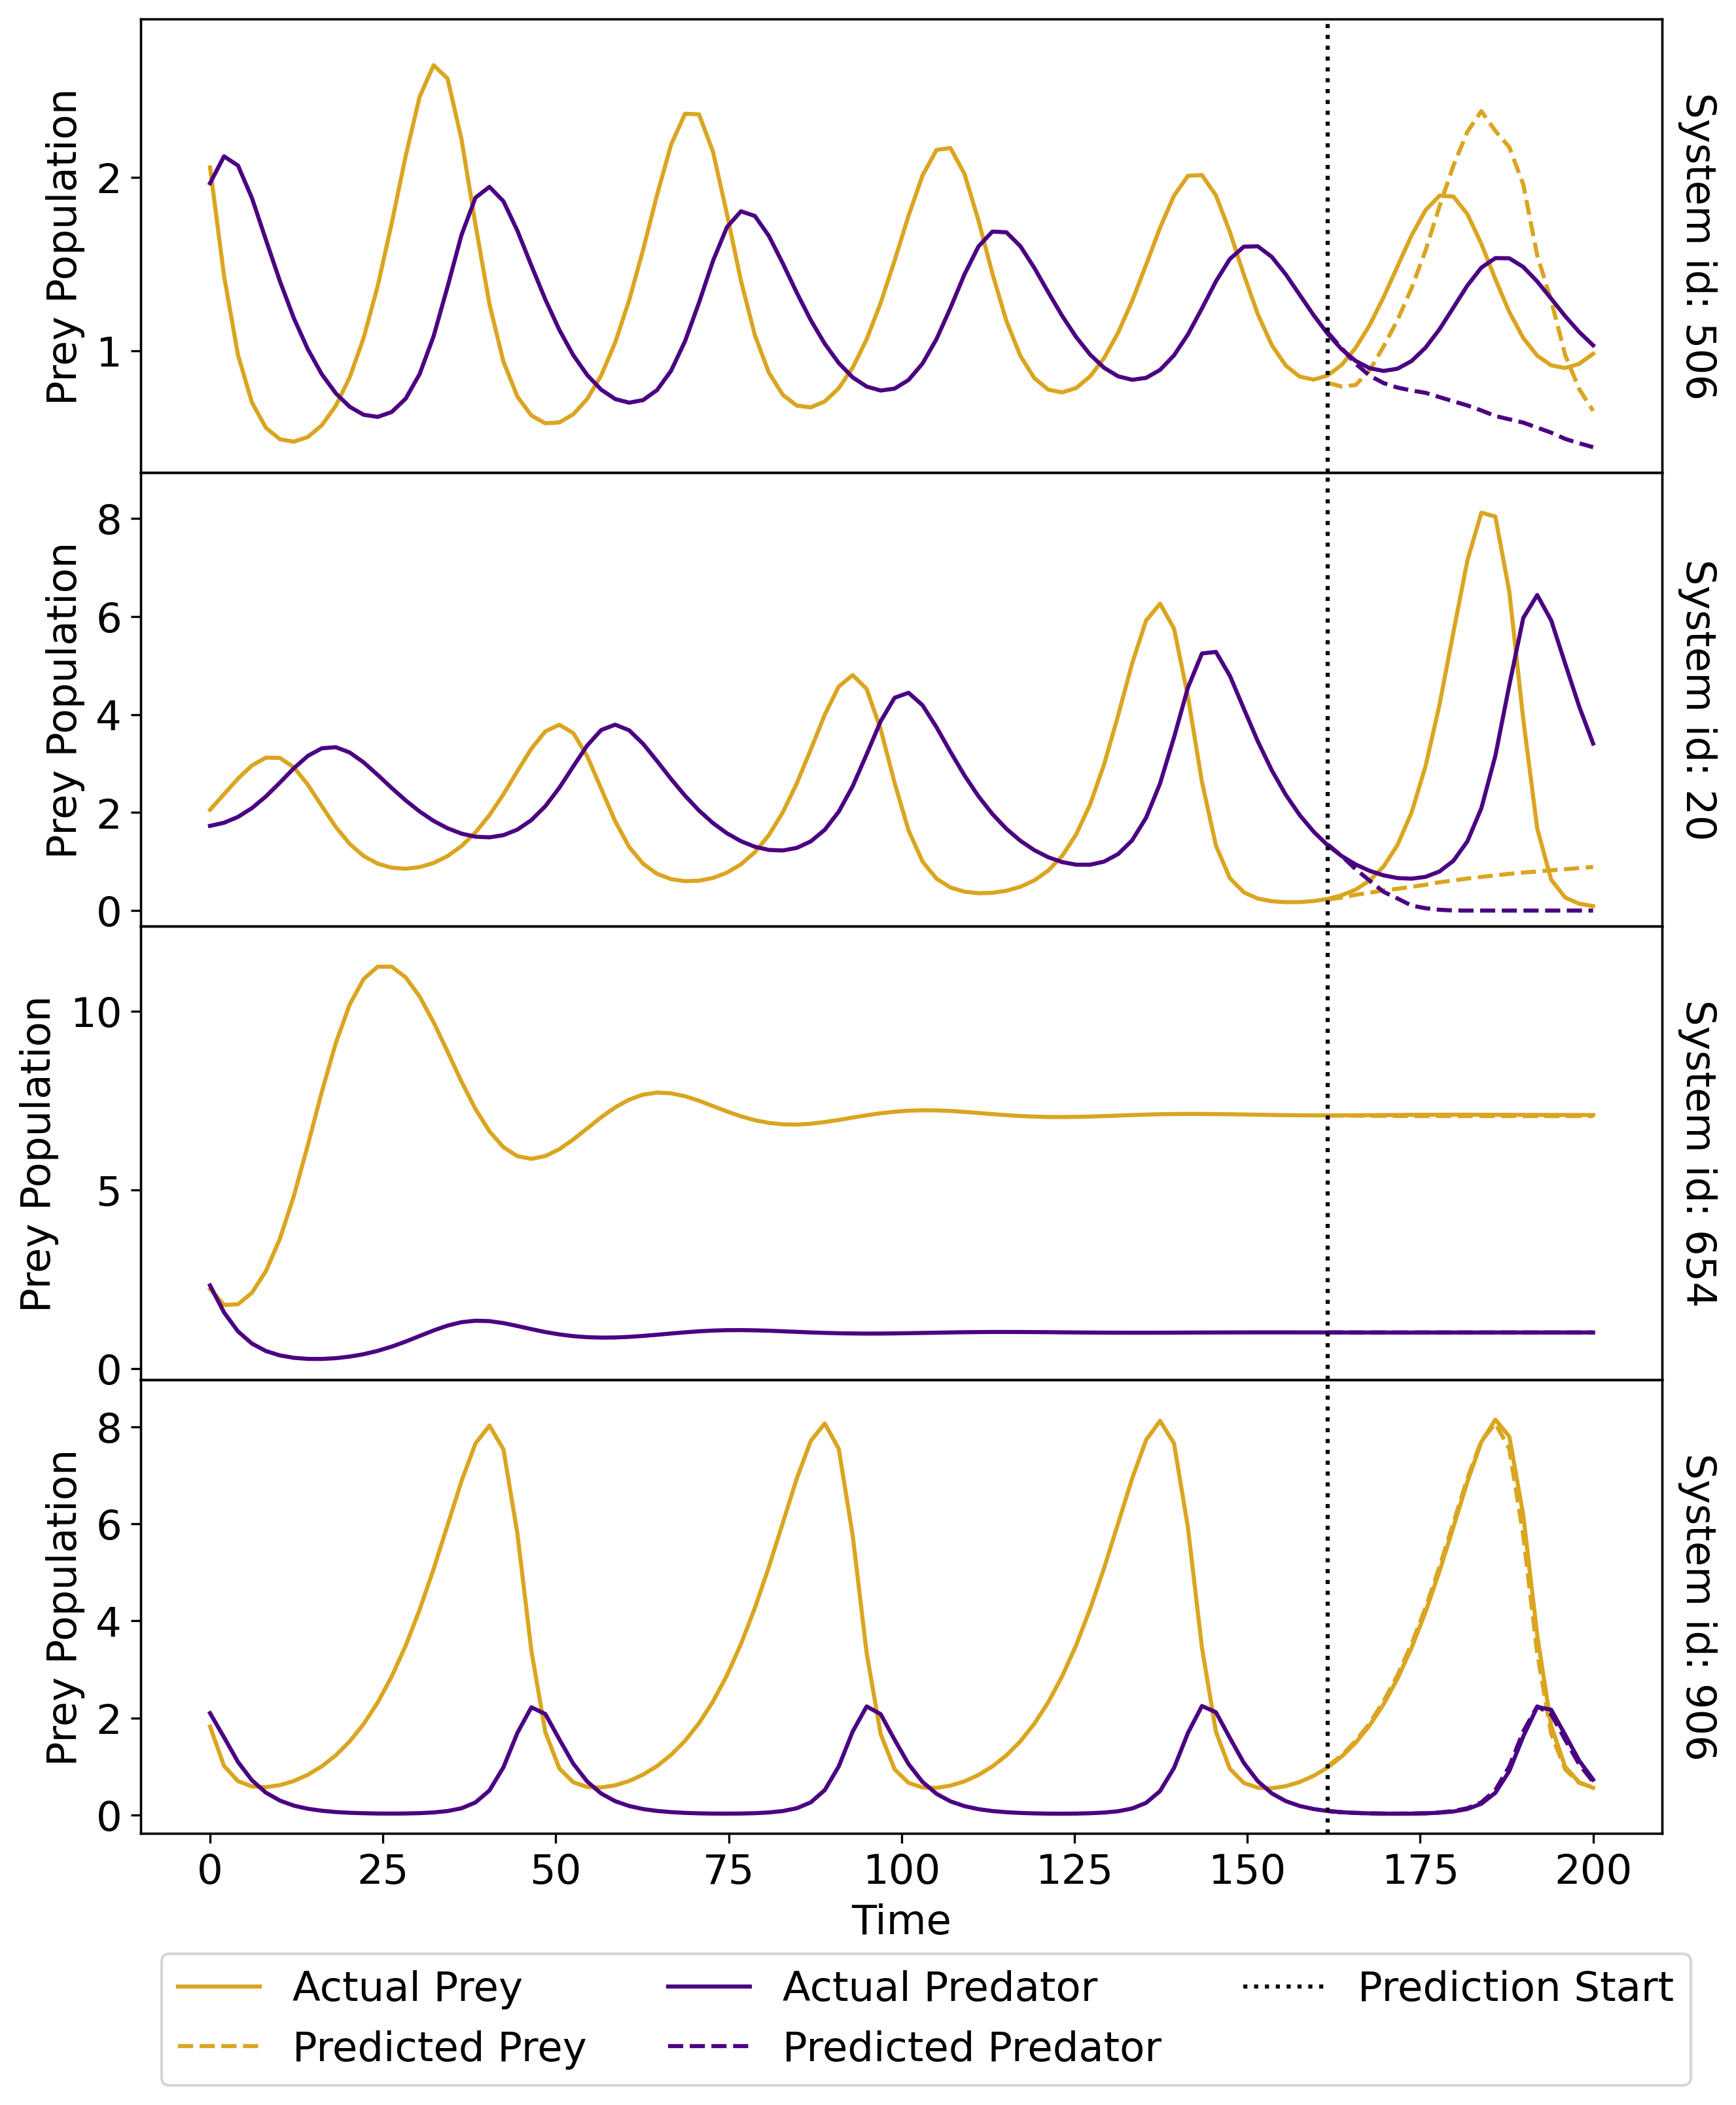

In [12]:
fig, ax = plt.subplots(len(actual_system_ids), 1, figsize=(10, 3*len(actual_system_ids)), sharex=True, dpi=300)
for i, id in enumerate(actual_system_ids):
    ax[i].plot(full_times, actual_preys[i], label='Actual Prey', color='goldenrod')
    ax[i].plot(full_times[80:], predicted_preys[i][80:], label='Predicted Prey', color='goldenrod', linestyle='dashed')
    ax[i].plot(full_times, actual_predators[i], label='Actual Predator', color='indigo')
    ax[i].plot(full_times[80:], predicted_predators[i][80:], label='Predicted Predator', color='indigo', linestyle='dashed')
    ax[i].axvline(x=full_times[80], color='black', linestyle='dotted', label='Prediction Start')
    twin_axis = ax[i].twinx()
    twin_axis.set_ylabel(fr'System id: {id}', rotation=270, fontsize=SMALL_SIZE-5, labelpad=20)
    twin_axis.set_yticks([])
    ax[i].set_ylabel('Prey Population')
    ax[i].set_ylim(min(actual_preys[i].min(), actual_predators[i].min())*0.9-0.05*max(actual_preys[i].max(), actual_predators[i].max()), max(actual_preys[i].max(), actual_predators[i].max())*1.1)
ax[-1].set_xlabel('Time')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(0, -0.6), ncol=3, fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig("../plots/predictions_example.png", bbox_inches='tight', dpi=300)
plt.show()

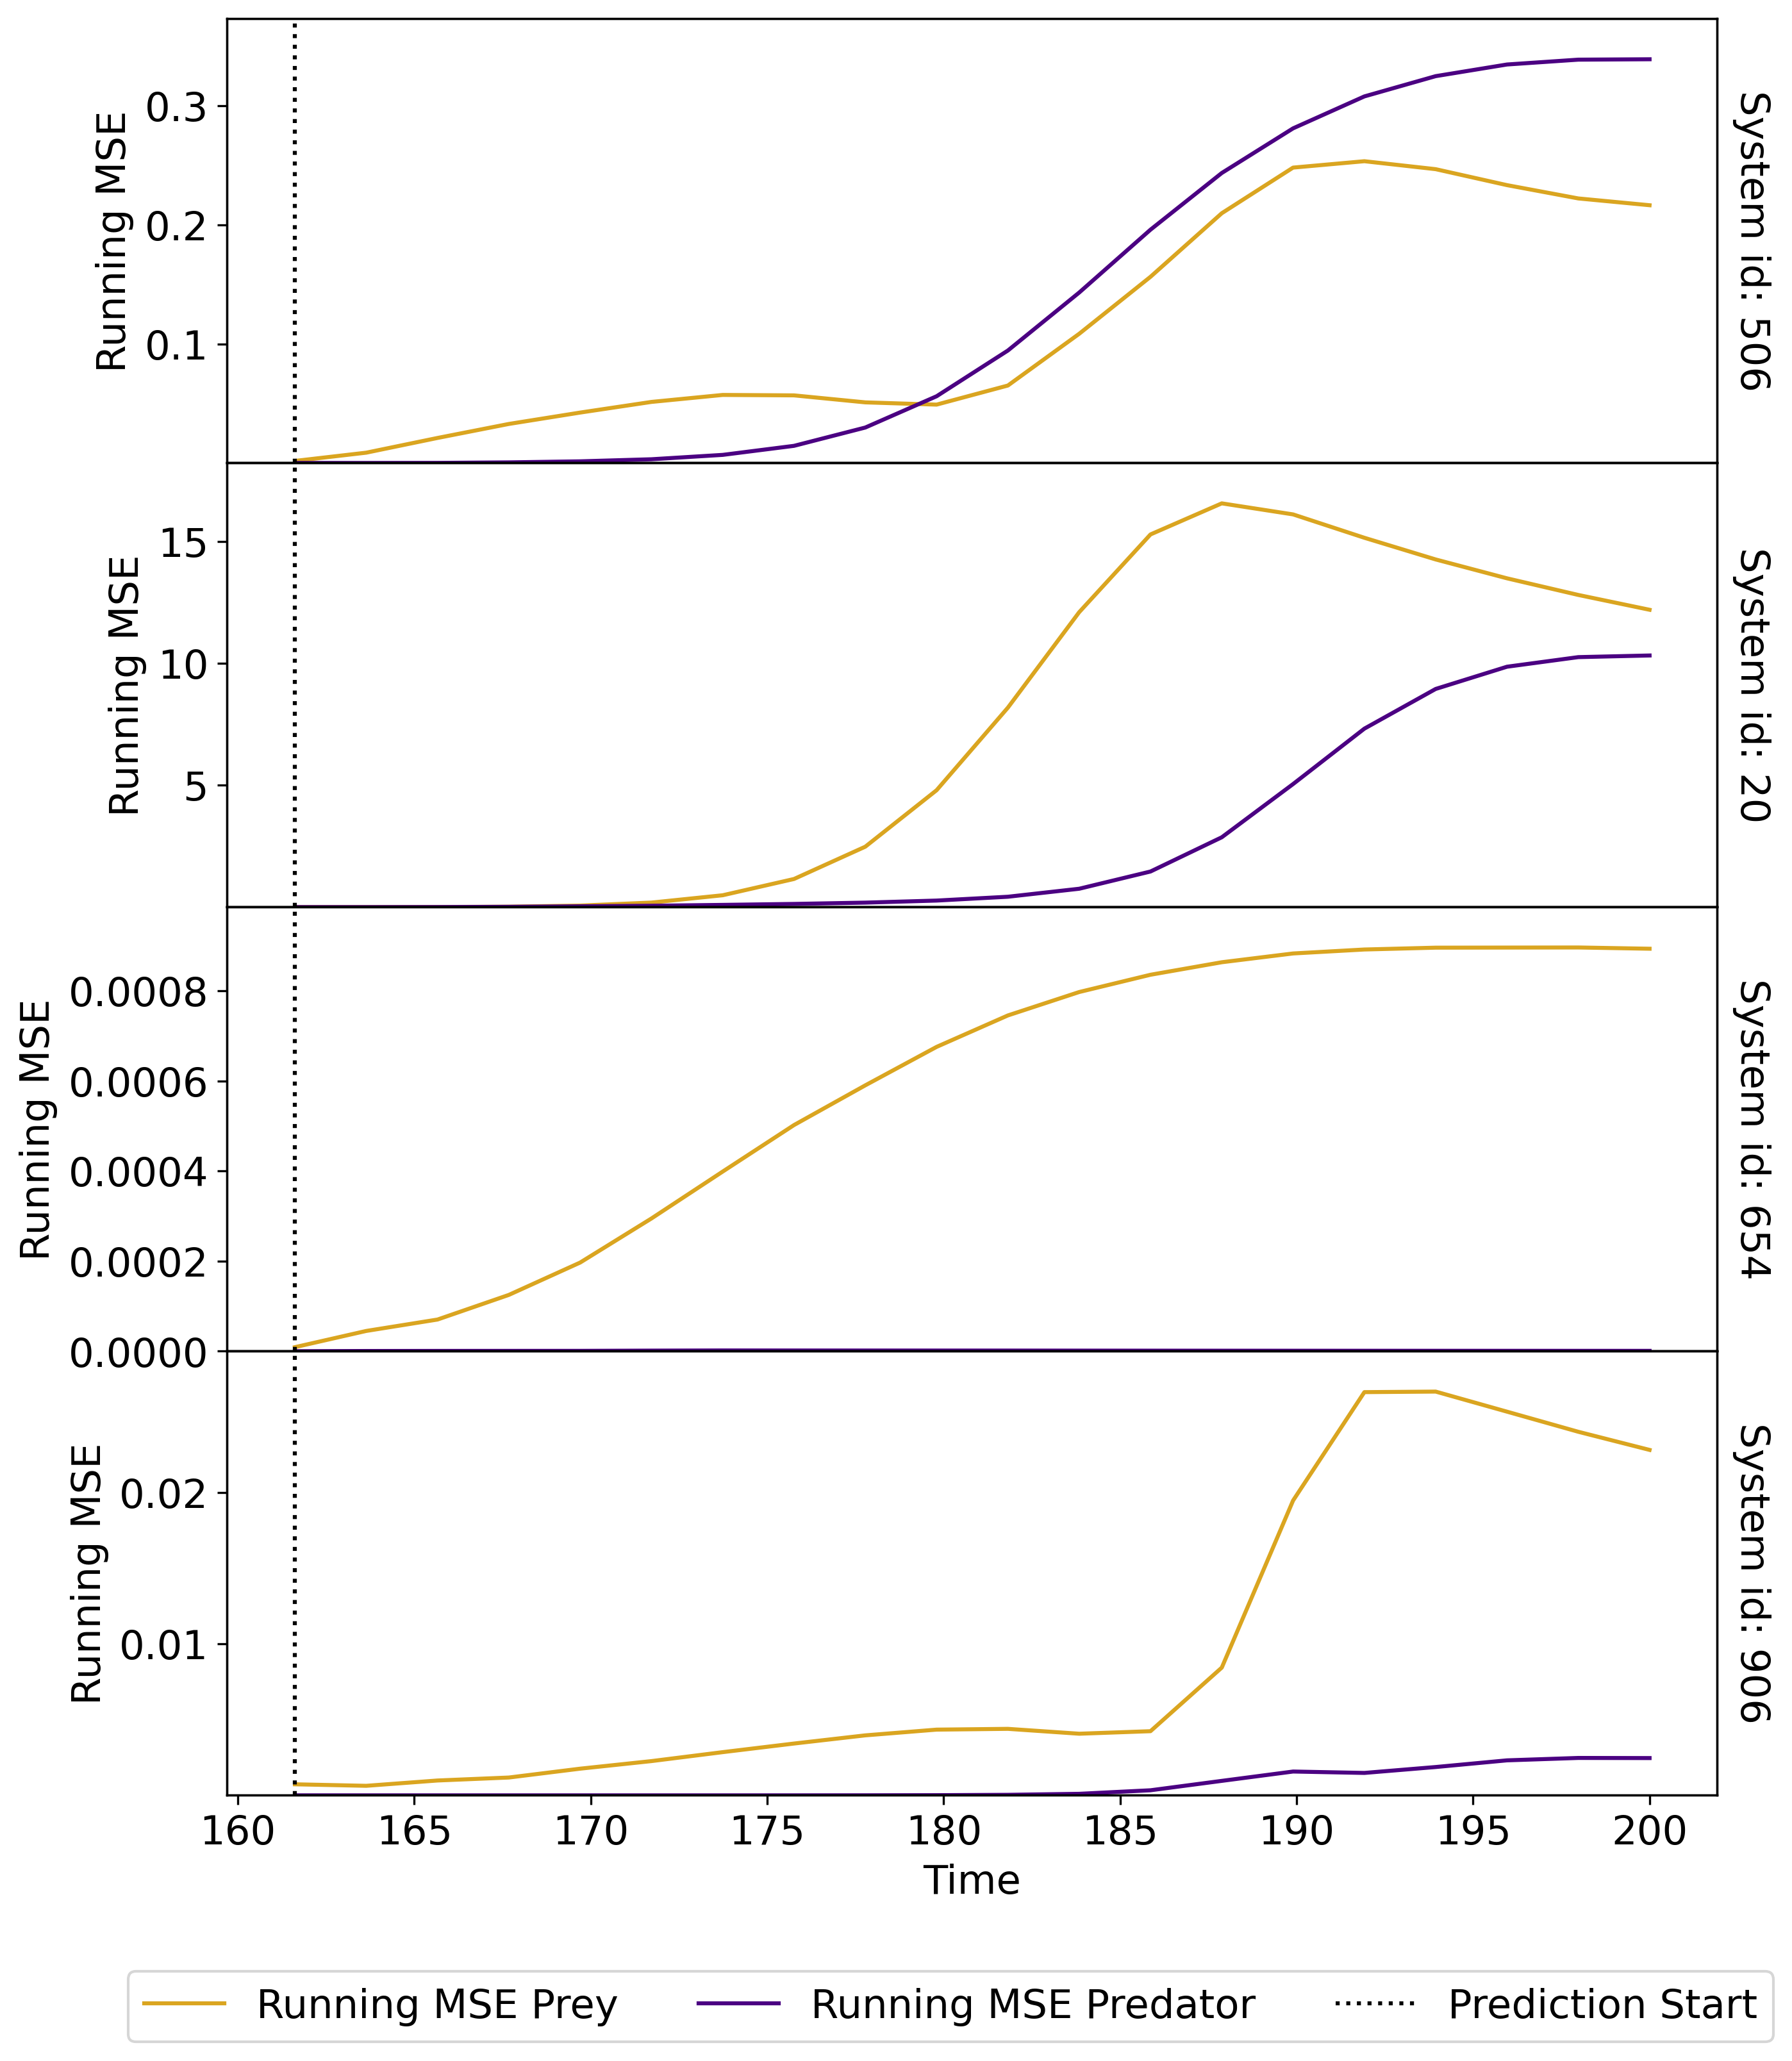

In [24]:
metrics = get_metrics(actual_preys, actual_predators, predicted_preys, predicted_predators)
fig, ax = plt.subplots(len(actual_system_ids), 1, figsize=(10, 3*len(actual_system_ids)), sharex=True, dpi=300)
for i, id in enumerate(actual_system_ids):
    ax[i].plot(full_times[80:], metrics[i][-2], label='Running MSE Prey', color='goldenrod')
    ax[i].plot(full_times[80:], metrics[i][-1], label='Running MSE Predator', color='indigo')
    ax[i].set_ylabel('Running MSE')
    ax[i].set_ylim(min(min(metrics[i][-2]), min(metrics[i][-1]))*0.5, max(max(metrics[i][-2]), max(metrics[i][-1]))*1.1)
    twin_axis = ax[i].twinx()
    twin_axis.set_ylabel(fr'System id: {id}', rotation=270, fontsize=SMALL_SIZE-5, labelpad=20)
    twin_axis.set_yticks([])
    ax[i].axvline(x=full_times[80], color='black', linestyle='dotted', label='Prediction Start')
ax[i].set_xlabel('Time')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(-0.08, -0.6), ncol=3, fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig(f"../plots/running_mse_example.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
def print_metrics(metrics, system_ids):
    df = pd.DataFrame(metrics, columns=["MSE Prey", "MSE Predator", "MAE Prey", "MAE Predator", "MAPE Prey", "MAPE Predator", "RMSE Prey", "RMSE Predator", "Running MSE Prey", "Running MSE Predator"])
    df["System ID"] = system_ids
    df.set_index("System ID", inplace=True)
    df = df.round(4)
    df.drop(columns=["Running MSE Prey", "Running MSE Predator"], inplace=True)
    display(df)

print_metrics(metrics, actual_system_ids)

,MSE Prey,MSE Predator,MAE Prey,MAE Predator,MAPE Prey,MAPE Predator,RMSE Prey,RMSE Predator
System ID,,,,,,,,
506,0.2166,0.3393,0.3724,0.4711,0.3005,0.3647,0.4654,0.5825
20,12.2073,10.3308,2.3852,2.3123,1.3317,0.7600,3.4939,3.2141
654,0.0009,0.0000,0.0282,0.0006,0.0040,0.0006,0.0299,0.0009
906,0.0228,0.0025,0.1026,0.0318,0.0309,0.0559,0.1510,0.0496


: 

In [15]:
def plotter(id):
    full_tokenized_data, full_preprocessed_data, full_data, full_times = load_and_process_example(file_path, tokenizer, points=100, alpha=5, decimals=3, seed=442, id=id)
    plt.plot(full_times, full_data[:,2], label='Actual Prey', color='goldenrod')
    plt.plot(full_times, full_data[:,3], label='Actual Predator', color='indigo')
    plt.show()

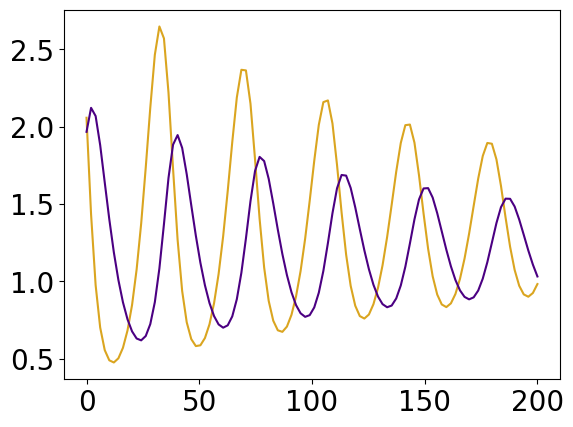

In [16]:
plotter(0)

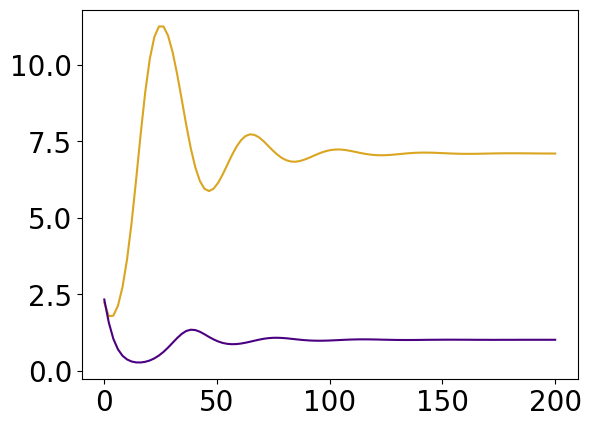

In [17]:
plotter(15)

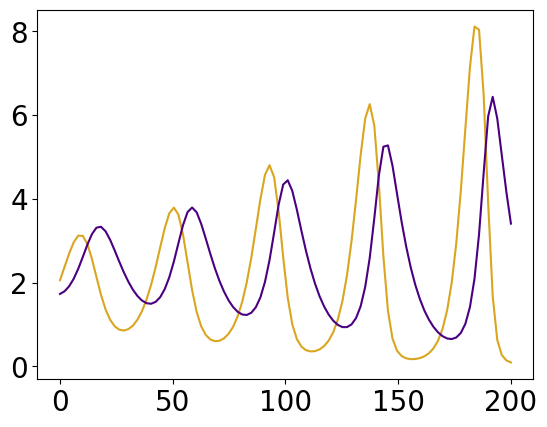

In [18]:
plotter(10)

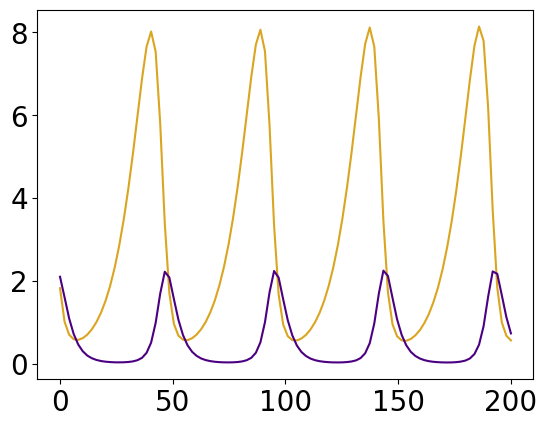

In [19]:
plotter(91)